### Описание проекта

Вы работаете в интернет-магазине, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Изучение данных из файла

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [3]:
df = pd.read_csv('games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Согласно документации к данным:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

*Данные за 2016 год могут быть неполными.


**Вывод**

В датафрейме присутвуют пераметры двух типов — object, float64; на первый взгляд требуется привести к другому типу столбцы `Year_of_Release` и `User_Score`.

Пропуски типа `NaN` содержатся в данных: 
- Name, 
- Year_of_Release, 
- Genre,
- Critic_Score,
- User_Score, Rating. 

Пропуски в столбце `Name` носят случайный характер, скорее всего в столбце `Genre` данные пропущенны из-за отсутвия названия (`Name`), так как пропущенные значения в этих столбцах содержатся только в двух записях, можно их удалить. Остальные пропуски в данных на первый взгляд можно оставить без изменений.

### Предобработка данных

Приведём названия столбцов в датафрейме к нижнему регистру:

In [5]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Замена типов данных**

Приведём переменную `year_of_release` к целочисленному типу: 

In [9]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

Заменим тип данных в столбцах `year_of_release`:

In [11]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

**Обработка пропусков**

In [12]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [13]:
# Удалим строки с пропущенными значеними в столбцах name и genre
df = df.dropna(subset=['name', 'genre']).reset_index(drop=True)

Посмотрим как распределны пропуски по `year_of_release` в зависимости от платформы:

**Посчитаем суммарные продажи во всех регионах и сохраним в столбец `sum_sale`**

In [14]:
df['sum_sale'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

**Вывод**

В столбце `user_score` есть нечисловое значение `tbd` — оценка ещё не выставлена (возможно потому, что данные ещё собираются). По построенной круговой диаграмме видно, как распределяются доли оценок пользователей 'tbd', можно выделить 2007-2011 гг. как года с наибольшим количеством. 

При приведении переменной к числовому типу, значения `tbd` были заменены на значения `NaN`.


### EDA

Посмотрим сколько игр выпускалось в разные годы:

In [15]:
# Сводная таблица количество выпущенных игр в год 
pivot_table_year = df.pivot_table(index='year_of_release', values='name', aggfunc=('count')).reset_index()

<AxesSubplot:title={'center':'Количество выпущенных игр в год'}, xlabel='year_of_release'>

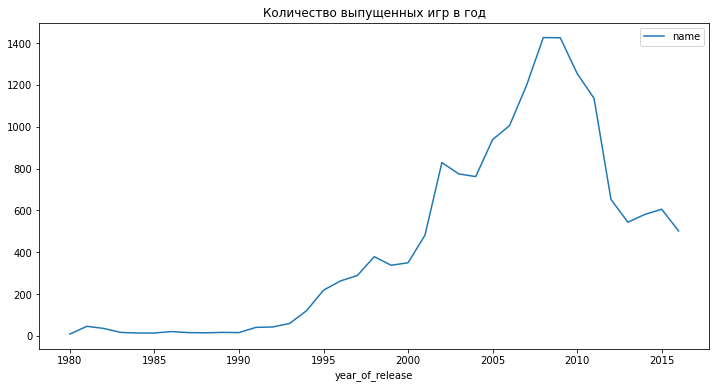

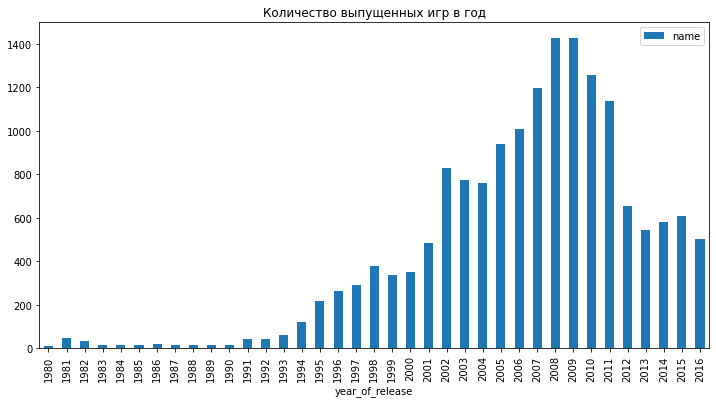

In [16]:
# Построение графика по сводной таблице pivot_table_year
pivot_table_year.plot(x='year_of_release', y='name', title='Количество выпущенных игр в год', figsize=(12,6))
pivot_table_year.plot(x='year_of_release', y='name', title='Количество выпущенных игр в год', kind='bar', figsize=(12,6))

Из графика видно, что самое большое количество игр было выпущенно в период с 2006 по 2010, а пик приходится на 2008 год.

Количество выпущенных игр в период с 1980 - 1994 в среднем 32 игры в год, это может быть связано с началом развития этого направления технологий, вряд ли этот период будет полезен для анализа данных и решения поставленной задачи, поэтому далее будем рассматривать данные за 1995 - по 2016:

In [17]:
# Срез данных по году выпуска игр
df = df.query('year_of_release >= 1995')

Продажи по платформам:

<AxesSubplot:title={'center':'Распределение продаж в зависимости от платформы'}, xlabel='platform'>

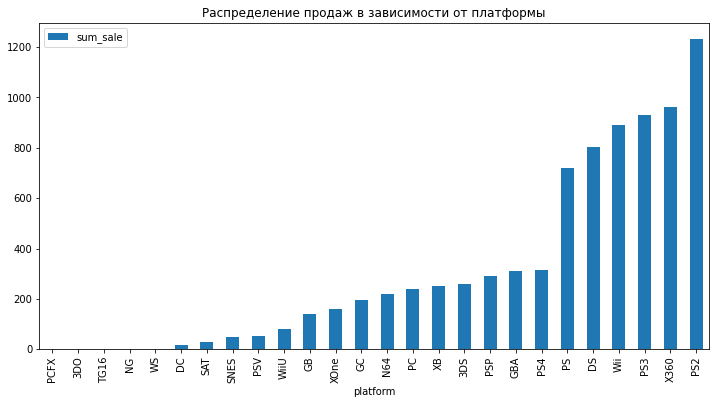

In [18]:
df.pivot_table(index='platform', values='sum_sale', aggfunc=('sum')
              ).reset_index().sort_values(by='sum_sale').plot(x='platform', y='sum_sale', kind='bar', 
                                   title='Распределение продаж в зависимости от платформы', figsize=(12,6))

Из графика распределения сумарных продаж в зависимости от платформы можно выделить несколько платформ с высокими продажами: DS, PS, PS2, PS3, Wii, X360. Посмотрим как для данных платформ распределяются сумарные продажи по годам:

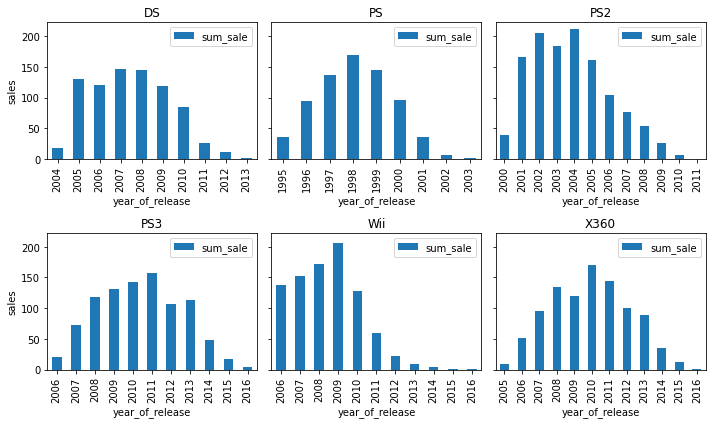

In [20]:
fig, axes = plt.subplots(2,3,figsize=(10, 6), sharey=True)

for reg, ax in zip(['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'],axes.flat):
     data = df.query('platform == @reg')
     data.pivot_table(index='year_of_release', values='sum_sale', aggfunc='sum').plot(kind='bar',title=reg, ax=ax)
     ax.set_ylabel('sales')
    
plt.tight_layout()

**Вывод**

Сумарные продажи по отобранным платформам:

- Для платформы DS продажи резко выросли в 2005 г. и достигли максимума в 2007 г., за тем постпенно начали убывать и к 2013 г. практически достигли первоначальных объемов;
- У платформы PS пик продаж приходится на 1998 г. Рост начался с 1994 г. и максимальный спад на 2003 и это последний год;
- Для платформы PS2 продажи начинаются с 2000 г., пик приходится на 2002 г., в 2011г. продажи прекращаются;
- Для платформы PS3 продажи начинаются в 2006 г., пик суммарных продаж приходится на 2011 г. далее продажи снижаюся и в 2016 г. продажи ниже чем вначале.
- Для платформы Wii продажи начинаются в2006 г., постепенный рост и пик достигается в 2009, к 2011 году резкий спад продаж, в 2016 году минимальные продажи.
- Для платформы X360 период продаж 2005 - 2016 г. Пик продаж в 2010 г.

Поскольку данные за 2016 год не полные, не будем делать вывод о суммарных продажах опираясь на этот год.
 
Можно заметить, что платформы PS, PS2, PS3  появляются с разницей в 6 лет. 

После 2011 г. происходит резкий спад количества выпущенных игр в год. Также из построенных гистограмм для среза данных по платформам видно, что с 2012 падают сумарные продажи. Для построения прогноза на 2017 год далее будем исследовать данные за 2012-2016 гг.

In [21]:
# срез данных 2012-2016 гг.
df = df.query('year_of_release >= 2012')

<AxesSubplot:title={'center':'Распределение продаж в зависимости от платформы'}, xlabel='platform'>

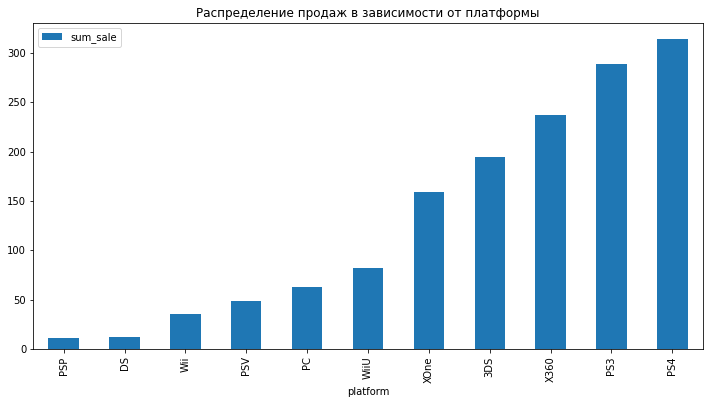

In [22]:
df.pivot_table(index='platform', values='sum_sale', aggfunc=('sum')
              ).reset_index().sort_values(by='sum_sale').plot(x='platform', y='sum_sale', kind='bar', 
                                   title='Распределение продаж в зависимости от платформы', figsize=(12, 6))

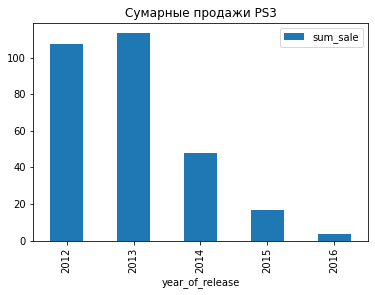

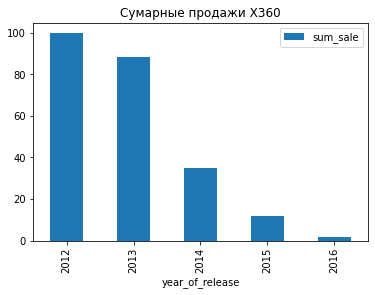

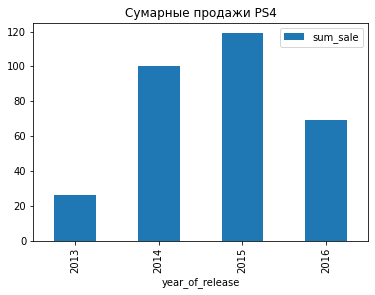

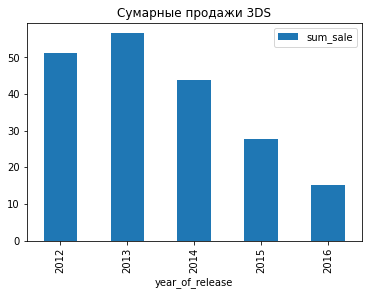

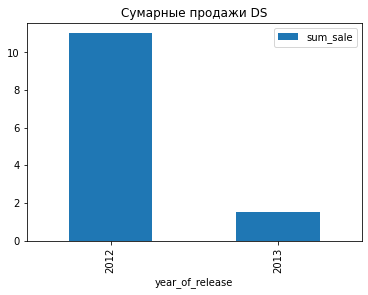

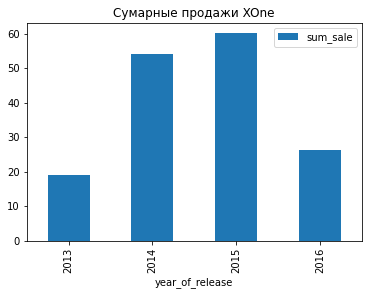

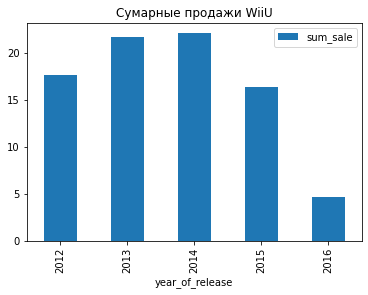

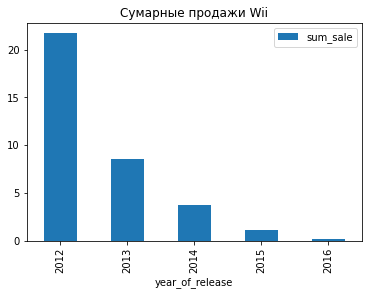

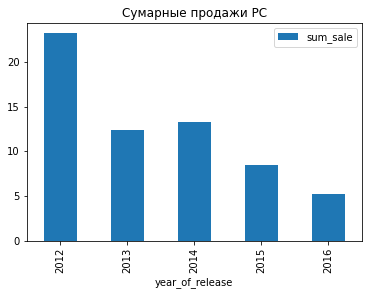

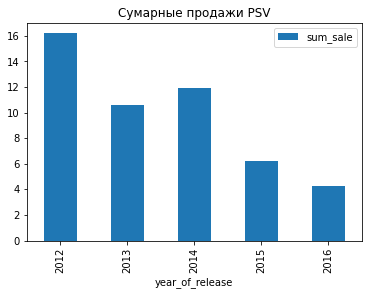

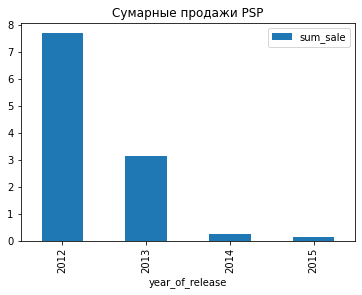

In [23]:
val_ls = df['platform'].unique()
for val in val_ls:
    data = df.query('platform == @val')
    data.pivot_table(index='year_of_release', values='sum_sale', aggfunc='sum').reset_index().plot(
        x='year_of_release', y='sum_sale', kind='bar', title = ('Сумарные продажи '+ val))

**Вывод**
- Продажи растут: PS4, XOne;
- Продажи падают: PS3, X360, 3DS, WiiU, Wii, PC, PSV, PSP;
- Платформы лидирующие по продажам за период 2012-2013 гг.: PS3, X360, PS4, XOne;

Выберем потенциально прибыльные платформы (платформы чьи продажи растут): PS4, XOne.

**Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.**

In [24]:
data = df.query('platform.isin(["PS3", "PS4", "XOne"])')

(0.0, 5.0)

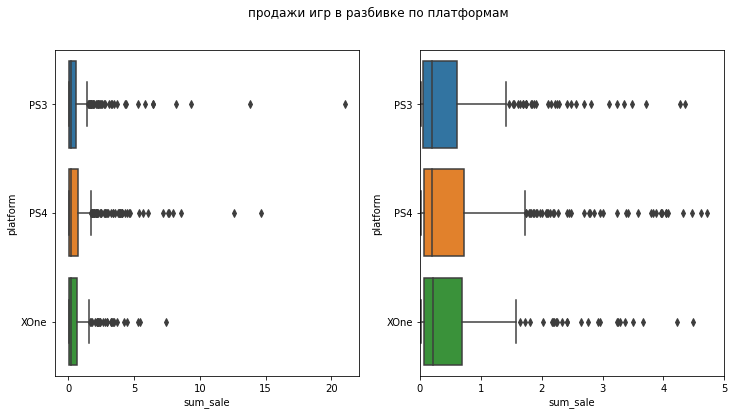

In [25]:
fig, ax = plt.subplots(1, 2, sharex=False, figsize=(12, 6))

fig.suptitle("продажи игр в разбивке по платформам")
sns.boxplot(ax=ax[0], data=data, x='sum_sale', y='platform')
sns.boxplot(ax=ax[1], data=data, x='sum_sale', y='platform').set_xlim(0, 5)

**Вывод**

Из построенных графиков видно, что медианы по суммарным продажам у платформ — "PS3", "PS4", "XOne", практически  равны. На графике также видны выбросы, это игры с очень высокими продажами, именно за счет этих выбросов платформа зарабатывает основную часть дохода. 


**Среди потенциально успешных платформ выберем одну (`PS4`) и посмотрим, как влияют на продажи отзывы пользователей и критиков.**

<AxesSubplot:title={'center':'user_score VS sum_sale'}, xlabel='user_score', ylabel='sum_sale'>

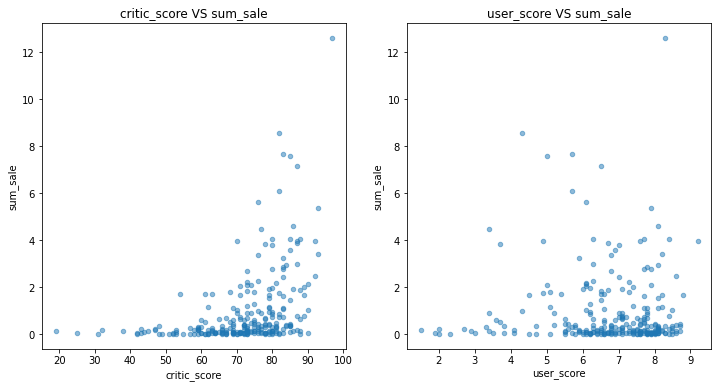

In [26]:
# PS4
data = df.query('platform == "PS4"')

# Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

data.plot(y='sum_sale', x='critic_score', title='critic_score VS sum_sale', kind='scatter', alpha=0.5, ax=ax[0])
data.plot(y='sum_sale', x='user_score', title='user_score VS sum_sale', kind='scatter', alpha=0.5, ax=ax[1])


На диаграммах рассеиния заметны выбросы, для подсчёта коэффициента корреляции, удалим их из данных:

In [27]:
data = data.query('sum_sale < 5')

In [28]:
print("Корреляция между отзывами и продажами\n", data[['critic_score', 'user_score', 'sum_sale']].corr(), sep='\n')

Корреляция между отзывами и продажами

              critic_score  user_score  sum_sale
critic_score      1.000000    0.582984   0.40208
user_score        0.582984    1.000000   0.01458
sum_sale          0.402080    0.014580   1.00000


<!-- По диаграмме рассеяния между отзывами критиков и продажами можно увидеть зависимость, с увеличением оценки критиков появляется и рост продаж, об этом же нам говорит расчитанный коэффициент корреляции, равный 0.41, есть слабая прямолинейная зависимость.

Кэффициент корреляции между отзывами пользователей и продажами равен -0.03 — взаимозависимость между параметрами слабая. -->

Зависимость продаж игр от оценок пользователей и критиков на других платформах:

PS3
              critic_score  user_score  sum_sale
critic_score      1.000000    0.563524  0.455296
user_score        0.563524    1.000000  0.027896
sum_sale          0.455296    0.027896  1.000000


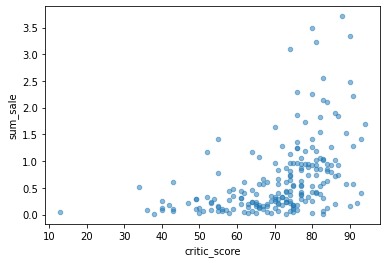

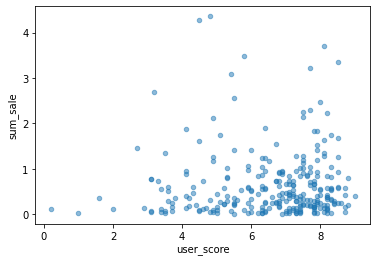

XOne
              critic_score  user_score  sum_sale
critic_score      1.000000    0.471964  0.407140
user_score        0.471964    1.000000 -0.085555
sum_sale          0.407140   -0.085555  1.000000


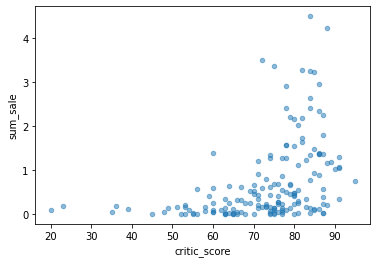

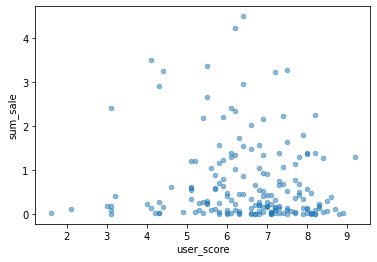

In [29]:
data = df.query('platform.isin(["PS3", "XOne"])')

for platform, games_on_platform in data.query('sum_sale < 5').groupby('platform'):
    print(platform)   

    games_on_platform.plot(kind='scatter', x='critic_score', y='sum_sale', alpha=0.5)
    games_on_platform.plot(kind='scatter', x='user_score', y='sum_sale', alpha=0.5)

    print(games_on_platform[['critic_score', 'user_score', 'sum_sale']].corr())
    plt.show()

**Вывод**

Для платформ "PS4", "PS3", "XOne"

- Рассчитанный коэффициент корреляции между продажами игр и оценкой пользователей очень низкий для всех платформ, что означает слабую прямолинейную зависимость между рассматриваемыми параметрами.

- Рассчитанный коэффициент корреляции между продажами игр и оценкой критиков для всех платформ 0.4 - 0.45 , что может означать зависимость между рассматриваемыми параметрами.



 **Общее распределение игр по жанрам** 

<AxesSubplot:xlabel='genre'>

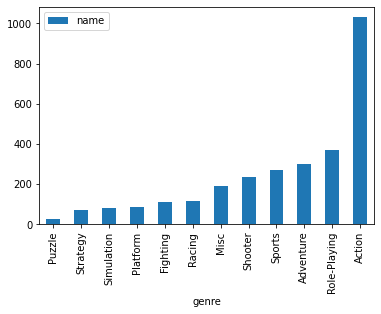

In [30]:
# гистограмма распределения игр по жанрам
df.pivot_table(index='genre', values='name', aggfunc=('count')).reset_index().sort_values(by='name').plot('genre', kind='bar')

Раcпределение медианы суммарных продаж относительно жанра:

<AxesSubplot:xlabel='genre'>

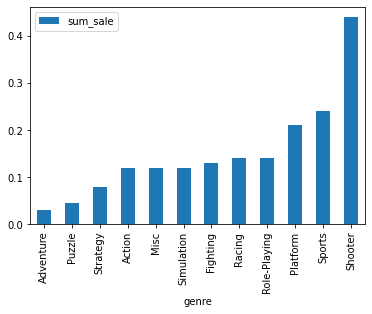

In [32]:
df.pivot_table(index='genre', values='sum_sale', aggfunc=('median')).reset_index().sort_values(by='sum_sale').plot('genre', kind='bar')

**Вывод**

- По гистограмме распределения игр по жанрам, можно сделать вывод, что самые популярные жанры среди производителей игр: 'Action', 'Role-Playing', 'Adventure', 'Sports';
- Самые прибыльные жанры: 'Shooter', 'Sports', 'Platform', 'Role-Playing'.

Самые высокие продажи у игр жанра 'Shooter', самые низкие продажи у игр жанра 'Adventure'.

### Шаг 4. Составьте портрет пользователя каждого региона



Определите для пользователя каждого региона (NA, EU, JP):

-	Самые популярные платформы (топ-5). Опишите различия в долях продаж.
-	Самые популярные жанры (топ-5). Поясните разницу.
-	Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Самые популярные платформы (топ-5)**

In [33]:
# Самые популярные платформы NA
print("популярные платформы NA")
df_na = df.pivot_table(index='platform', values=['na_sales', 'sum_sale'], aggfunc='sum').reset_index()
# доля продаж 
df_na['part'] = df_na['na_sales'] / df_na['sum_sale']
display(df_na.sort_values(by='na_sales', ascending=False)[['platform','part']].head())

# Самые популярные платформы EU
print("\nпопулярные платформы EU")
df_eu = df.pivot_table(index='platform', values=['eu_sales', 'sum_sale'], aggfunc='sum').reset_index()
# доля продаж 
df_eu['part'] = df_eu['eu_sales'] / df_eu['sum_sale']
display(df_eu.sort_values(by='eu_sales', ascending=False)[['platform', 'part']].head())

# Самые популярные платформы JP
print("\nпопулярные платформы JP")
df_jp = df.pivot_table(index='platform', values=['jp_sales', 'sum_sale'], aggfunc='sum').reset_index()
# доля продаж 
df_jp['part'] = df_jp['jp_sales'] / df_jp['sum_sale']
display(df_jp.sort_values(by='jp_sales', ascending=False)[['platform', 'part']].head())

популярные платформы NA


,platform,part
9,X360,0.592077
4,PS4,0.346151
3,PS3,0.357976
10,XOne,0.584484
0,3DS,0.284209



популярные платформы EU


,platform,part
4,PS4,0.449131
3,PS3,0.370027
9,X360,0.315042
10,XOne,0.323814
0,3DS,0.219105



популярные платформы JP


,platform,part
0,3DS,0.451107
3,PS3,0.122200
6,PSV,0.427816
4,PS4,0.050805
8,WiiU,0.158292


Построим круговую диаграмму, чтобы рассмотреть доли продаж относительно платформы в каждом регионе:

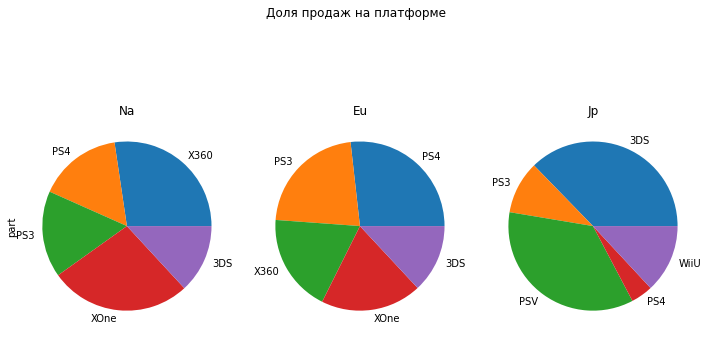

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
fig.suptitle("Доля продаж на платформе")
df_na.set_index('platform').sort_values(by='na_sales', ascending=False).head().plot(ax=ax[0], y='part', kind='pie', legend=False, title='Na')
df_eu.set_index('platform').sort_values(by='eu_sales', ascending=False).head().plot(ax=ax[1], y='part', kind='pie', legend=False,  title='Eu')
df_jp.set_index('platform').sort_values(by='jp_sales', ascending=False).head().plot(ax=ax[2], y='part', kind='pie', legend=False, title='Jp')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
plt.tight_layout()

**Самые популярные жанры (топ-5)**

In [35]:
# Самые популярные жанры NA
print("популярные жанры NA")
display(df.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head())

# Самые популярные жанры EU
print("\nпопулярные жанры EU")
display(df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head())

# Самые популярные жанры JP
print("\nпопулярные жанры JP")
df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head()

популярные жанры NA


genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64


популярные жанры EU


genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64


популярные жанры JP


genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64

**Влияние рейтинга ESRB на продажи в отдельном регионе**

Постром гистограммы распределения продаж относительно рейтинга ESRB:

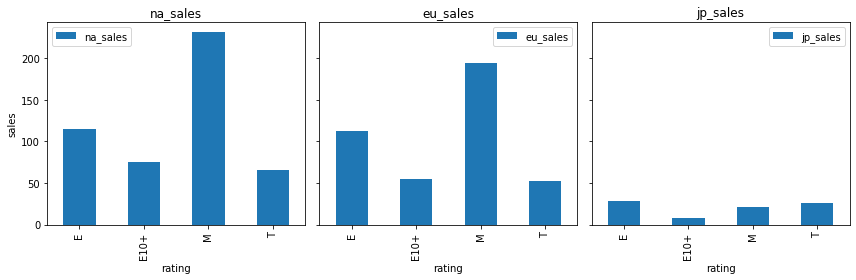

In [37]:
fig, axes = plt.subplots(1,3,figsize=(12,4), sharey=True)

for reg, ax in zip(['na_sales', 'eu_sales', 'jp_sales'],axes.flat):
     df.pivot_table(index='rating', values=reg, aggfunc=('sum')).plot(kind='bar',title=reg, ax=ax)
     ax.set_ylabel('sales')
    
plt.tight_layout()

In [38]:
df['rating'].value_counts()

M       498
T       412
E       395
E10+    306
Name: rating, dtype: int64

<AxesSubplot:ylabel='part'>

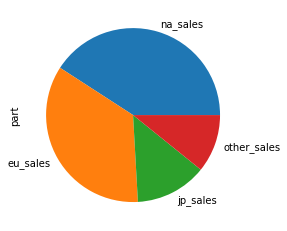

In [39]:
# Доли продаж по регионам
part_reg = pd.Series(
    [
    df['na_sales'].sum() / df['sum_sale'].sum(), 
    df['eu_sales'].sum() / df['sum_sale'].sum(), 
    df['jp_sales'].sum() / df['sum_sale'].sum(),
    df['other_sales'].sum() / df['sum_sale'].sum()
    ], 
                    index=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])

part_sales = pd.DataFrame({'part': part_reg })
part_sales.plot(y='part', kind='pie', legend=False)

**Вывод**

Для региона NA:

- самые популярные платформы: X360, PS4, PS3, XOne, 3DS
- самые популярные жанры: Action, Shooter, Sports, Role-Playing, Misc     
- больше всего продаж игр с рейтингом M(17+), меньше всего с рейтингом T(13-19 лет)

Для региона EU:

- самые популярные платформы в EU: PS4, PS3, X360, XOne, 3DS
- самые популярные жанры: Action, Shooter, Sports, Role-Playing, Racing
- больше всего продаж игр с рейтингом M(17+), меньше всего с рейтингом T(13-19 лет)

Для региона JP:

- самые популярные платформы в JP: 3DS, PS3, PSV, PS4, WiiU
- самые популярные жанры: Role-Playing, Action, Misc, Simulation, Fighting
- больше всего продаж игр с рейтингом E(для всех возрастов), меньше всего с рейтингом E10+

Из круговой диаграммы видно, что самые высоки продажи в Северной Америке, на втором месте Европа, на третьем Япония. 
В Северной Америке и Европе больше всего игр с рейтингом М(17+), это может быть связано и с тем что большая часть игр попадает под эту возрастную категорию. В Японии больше популярны игры в категории для всех. 

### Шаг 5. Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
	


Нулевая гипотеза $H_0: \mu_{xbox} = \mu_{pc}$

Альтернативная гипотеза $H_1: \mu_{xbox} \neq \mu_{pc}$

Для проверки гипотезы о равенстве двух средних воспользуемся методом `st.ttest_ind()`:

In [40]:
# Срез данных
df_xbox_one = df.query('platform == "XOne" and user_score.isna() == False')['user_score'].reset_index(drop=True)
df_pc = df.query('platform == "PC" and user_score.isna() == False')['user_score'].reset_index(drop=True)

In [41]:
# Выборочные дисперсии
print("xbox_one:", df_xbox_one.var())
print("\npc:", df_pc.var())

xbox_one: 1.9069968429360695

pc: 2.770443997158418


In [42]:
# Проверка гипотезы
alpha = .05
results = st.ttest_ind(df_xbox_one, df_pc, equal_var=False)
print("значение p-value:", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

значение p-value: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**Вывод**

С вероятностью 55% различие выборочных средних случайно, следовательно можно сделать вывод, что значимого различия в пользовательском рейтинге двух платформ (`Xbox One` и `PC`) нет.

- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


Нулевая гипотеза $H_0: \mu_{action} = \mu_{sports}$

Альтернативная гипотеза $H_1: \mu_{action} \neq \mu_{sports}$

Для проверки гипотезы о равенстве двух средних воспользуемся методом `st.ttest_ind()`:

In [43]:
# Срез данных
df_action  = df.query('genre == "Action" and user_score.isna() == False')['user_score'].reset_index(drop=True)
df_sports = df.query('genre == "Sports" and user_score.isna() == False')['user_score'].reset_index(drop=True)

In [44]:
# Выборочные дисперсии
print("df_action:", df_action.var())
print("\ndf_sports:", df_sports.var())

df_action: 1.8890840494348111

df_sports: 3.022890298704732


поскольку выборочные дисперсии различаются, параметр `equal_var` = False:

In [45]:
# Проверка гипотезы
alpha = .05   #уровень значимости
results = st.ttest_ind(df_xbox_one, df_pc, equal_var=False)
print("значение p-value:", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

значение p-value: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Данные предоставляют достаточное основание - для выбранного уровня значимости - отвергнуть нулевую гипотезу.
Можно сделать вывод, что пользовательский рейтинг зависит от жанра.

### Шаг 6. Общий вывод

Для интернет-магазина, по взятым из открытых источников историческим данным: продажи игр, оценки пользователей и экспертов, жанры и платформы, было проведено иследование и выявлено:

- самые популярные платформы:  X360, PS4, PS3, XOne, 3DS;
- пользовательский рейтинг не зависит от платформы, но зависит от жанра, так самыми популярными жанрами являются 'Action' и 'Shooter', минимальные продажи у игр жанра — 'Puzzle'; 
- в Северной Америке и Европе больше всего продаж игр с рейтингом M(17+), меньше всего с рейтингом T(13-19 лет);